LIBRARY INSTALLATION

In [ ]:
!pip install gensim

In [ ]:
!pip install numpy --upgrade --force-reinstall
!pip install gensim --upgrade --force-reinstall

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')


LOAD DATASET

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

EXPLORATION OF DATASET

Dataset Shape: (50000, 2)

Dataset Info:

Sample Data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


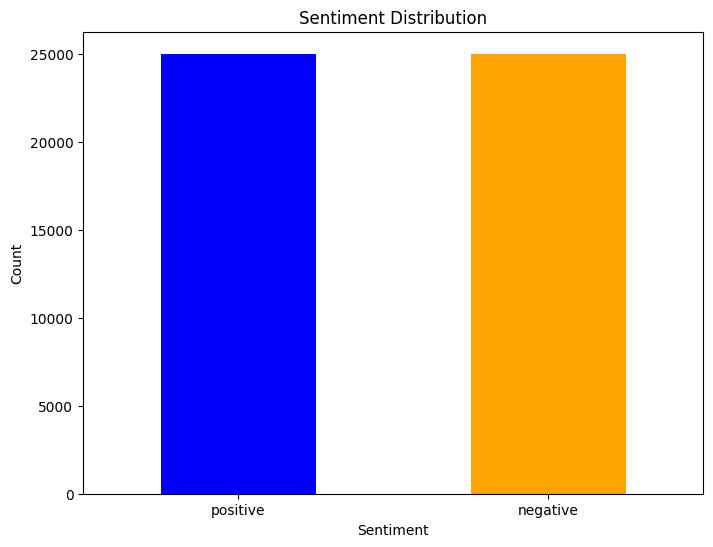

In [ ]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print("\nSample Data:")
print(df.head())
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



In [ ]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
sample_review = df['review'][0]
print("Original Review:\n", sample_review[:200], "...\n")
print("Cleaned Review:\n", clean_text(sample_review)[:200], "...")


Original Review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo ...

Cleaned Review:
 one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut ...


TOKENIZATION

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens
tokens = preprocess_text(sample_review)
print("Tokenized & Stopwords Removed:\n", tokens[:20], "...")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenized & Stopwords Removed:
 ['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'methe', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence'] ...


In [ ]:
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nlp = spacy.load('en_core_web_sm')

def analyze_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    return pos_tags[:20], entities[:5]
pos_tags, entities = analyze_text(sample_review)
print("POS Tags (first 20):\n", pos_tags)
print("\nNamed Entities (first 5):\n", entities)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


POS Tags (first 20):
 [('One', 'CD'), ('of', 'IN'), ('the', 'DT'), ('other', 'JJ'), ('reviewers', 'NNS'), ('has', 'VBZ'), ('mentioned', 'VBN'), ('that', 'IN'), ('after', 'IN'), ('watching', 'VBG'), ('just', 'RB'), ('1', 'CD'), ('Oz', 'NNP'), ('episode', 'NN'), ('you', 'PRP'), ("'ll", 'MD'), ('be', 'VB'), ('hooked', 'VBN'), ('.', '.'), ('They', 'PRP')]

Named Entities (first 5):
 [('One', 'CARDINAL'), ('1', 'CARDINAL'), ('GO', 'ORG'), ('OZ', 'ORG'), ('the Oswald Maximum Security State Penitentary', 'ORG')]


STEMMING&LEMMATIZATION

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
def stem_and_lemmatize(tokens):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    stemmed = [stemmer.stem(token) for token in tokens]
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    return stemmed, lemmatized
sample_tokens = tokens[:10]
stemmed, lemmatized = stem_and_lemmatize(sample_tokens)

print("Original Tokens:\n", sample_tokens)
print("\nStemmed:\n", stemmed)
print("\nLemmatized:\n", lemmatized)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Original Tokens:
 ['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly']

Stemmed:
 ['one', 'review', 'mention', 'watch', 'oz', 'episod', 'youll', 'hook', 'right', 'exactli']

Lemmatized:
 ['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly']


TEXT REPRESENTATION

In [ ]:
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
word2vec_model = api.load('word2vec-google-news-300')
def compare_word_similarities(model, word_pairs):
    print("\n Word Similarity Comparison:")
    print("=" * 50)
    for word1, word2 in word_pairs:
        try:
            similarity = model.similarity(word1, word2)
            category = "High" if similarity > 0.6 else "Moderate" if similarity > 0.3 else "Low"
            print(f"🔹 Similarity between '{word1}' & '{word2}': {similarity:.3f} ({category} similarity)")
        except KeyError:
            print(f" '{word1}' or '{word2}' not in vocabulary")
    print("=" * 50)
related_pairs = [('king', 'queen'), ('france', 'paris'), ('computer', 'laptop')]
context_pairs = [('breakfast', 'dinner'), ('happy', 'sad'), ('buy', 'sell')]
unrelated_pairs = [('pizza', 'computer'), ('sunshine', 'algebra'), ('elephant', 'guitar')]
compare_word_similarities(word2vec_model, related_pairs)
compare_word_similarities(word2vec_model, context_pairs)
compare_word_similarities(word2vec_model, unrelated_pairs)
print("\n BoW vs. TF-IDF Representation:")
example_text = ["This movie was great! I really loved the amazing acting and brilliant story"]
bow_vectorizer = CountVectorizer()
bow_features = bow_vectorizer.fit_transform(example_text)
bow_dict = dict(zip(bow_vectorizer.get_feature_names_out(), bow_features.toarray()[0]))
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(example_text)
tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_features.toarray()[0]))
print("\n🔹 Bag of Words (Word Counts):")
for word, count in sorted(bow_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"'{word}': {int(count)} occurrences")

print("\n🔹 TF-IDF (Term Importance):")
for word, score in sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"'{word}': {score:.3f} importance score")


[==================================================] 100.0% 1662.8/1662.8MB downloaded

 Word Similarity Comparison:
🔹 Similarity between 'king' & 'queen': 0.651 (High similarity)
🔹 Similarity between 'france' & 'paris': 0.555 (Moderate similarity)
🔹 Similarity between 'computer' & 'laptop': 0.664 (High similarity)

 Word Similarity Comparison:
🔹 Similarity between 'breakfast' & 'dinner': 0.701 (High similarity)
🔹 Similarity between 'happy' & 'sad': 0.535 (Moderate similarity)
🔹 Similarity between 'buy' & 'sell': 0.831 (High similarity)

 Word Similarity Comparison:
🔹 Similarity between 'pizza' & 'computer': 0.158 (Low similarity)
🔹 Similarity between 'sunshine' & 'algebra': 0.041 (Low similarity)
🔹 Similarity between 'elephant' & 'guitar': 0.031 (Low similarity)

 BoW vs. TF-IDF Representation:

🔹 Bag of Words (Word Counts):
'acting': 1 occurrences
'amazing': 1 occurrences
'and': 1 occurrences
'brilliant': 1 occurrences
'great': 1 occurrences
'loved': 1 occurrences
'movie': 1 occurren

IMPLEMENTATION USING deep learning

In [ ]:
from tqdm import tqdm

# Enable progress_apply for pandas
tqdm.pandas()

# Apply preprocessing function with progress tracking
df['processed_text'] = df['review'].progress_apply(preprocess_text)

# Join tokens back into a single string for TF-IDF vectorization
df['processed_text'] = df['processed_text'].apply(lambda tokens: ' '.join(tokens))

print("✅ All reviews preprocessed and ready for vectorization!")


100%|██████████| 50000/50000 [00:57<00:00, 869.73it/s]


✅ All reviews preprocessed and ready for vectorization!


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Tokenized Data for Neural Networks ---
print(" Preparing tokenized sequences for neural network models...")
max_words = 10000  # Vocabulary size
max_len = 200      # Max length of input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text'])

# Convert texts to sequences and pad them
X_seq = tokenizer.texts_to_sequences(df['processed_text'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Split padded sequences for training/testing
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)





 Preparing tokenized sequences for neural network models...


In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def create_nn_model(model_type='simple'):

    model = tf.keras.Sequential()

    # Add embedding layer to convert words into dense vectors
    model.add(tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len))

    # Choose model architecture based on type
    if model_type == 'simple':
        model.add(tf.keras.layers.GlobalAveragePooling1D())
    elif model_type == 'rnn':
        model.add(tf.keras.layers.SimpleRNN(units=32))
    elif model_type == 'lstm':
        model.add(tf.keras.layers.LSTM(units=32))
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Add hidden and output layers
    model.add(tf.keras.layers.Dense(units=16, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Binary classification output

    return model

def train_evaluate_nn(model_name, model_type, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a neural network model.

    Parameters:
        model_name (str): Friendly name for the model (for display).
        model_type (str): Model architecture type ('simple', 'rnn', or 'lstm').
        X_train, X_test, y_train, y_test: Dataset splits.

    Returns:
        dict: Training results including accuracy, report, and training history.
    """
    print(f"\n🚀 Starting training for: {model_name} ({model_type})")

    # Create and compile the model
    model = create_nn_model(model_type)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=3,                # Keep epochs small for quick training
        batch_size=128,
        validation_split=0.2,
        verbose=1
    )

    print(f" Finished training for: {model_name}")

    # Make predictions and evaluate
    predictions = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    matrix = confusion_matrix(y_test, predictions)

    print(f" Evaluation results for {model_name}:\nAccuracy: {acc:.4f}")

    return {
        'name': model_name,
        'accuracy': acc,
        'report': report,
        'confusion_matrix': matrix,
        'history': history.history
    }

# Define the models to evaluate
nn_models = [
    ('Simple Neural Network', 'simple'),
    ('Recurrent Neural Network (RNN)', 'rnn'),
    ('Long Short-Term Memory (LSTM)', 'lstm')
]

# Train and collect results for each model
nn_results = []
for model_name, model_type in nn_models:
    result = train_evaluate_nn(model_name, model_type, X_train_pad, X_test_pad, y_train_pad, y_test_pad)
    nn_results.append(result)



🚀 Starting training for: Simple Neural Network (simple)
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6470 - loss: 0.6665 - val_accuracy: 0.8424 - val_loss: 0.4637
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8473 - loss: 0.4063 - val_accuracy: 0.8780 - val_loss: 0.3212
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8866 - loss: 0.2918 - val_accuracy: 0.8840 - val_loss: 0.2937
 Finished training for: Simple Neural Network
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Evaluation results for Simple Neural Network:
Accuracy: 0.8839

🚀 Starting training for: Recurrent Neural Network (RNN) (rnn)
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5910 - loss: 0.6431 - val_accuracy: 0.8342 - val_loss: 0.3792
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.8775 - loss: 0.3039 - val_accuracy: 0.8749 - val_loss: 0.3210
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.9328 - loss: 0.1833 

 Generating accuracy comparison chart...


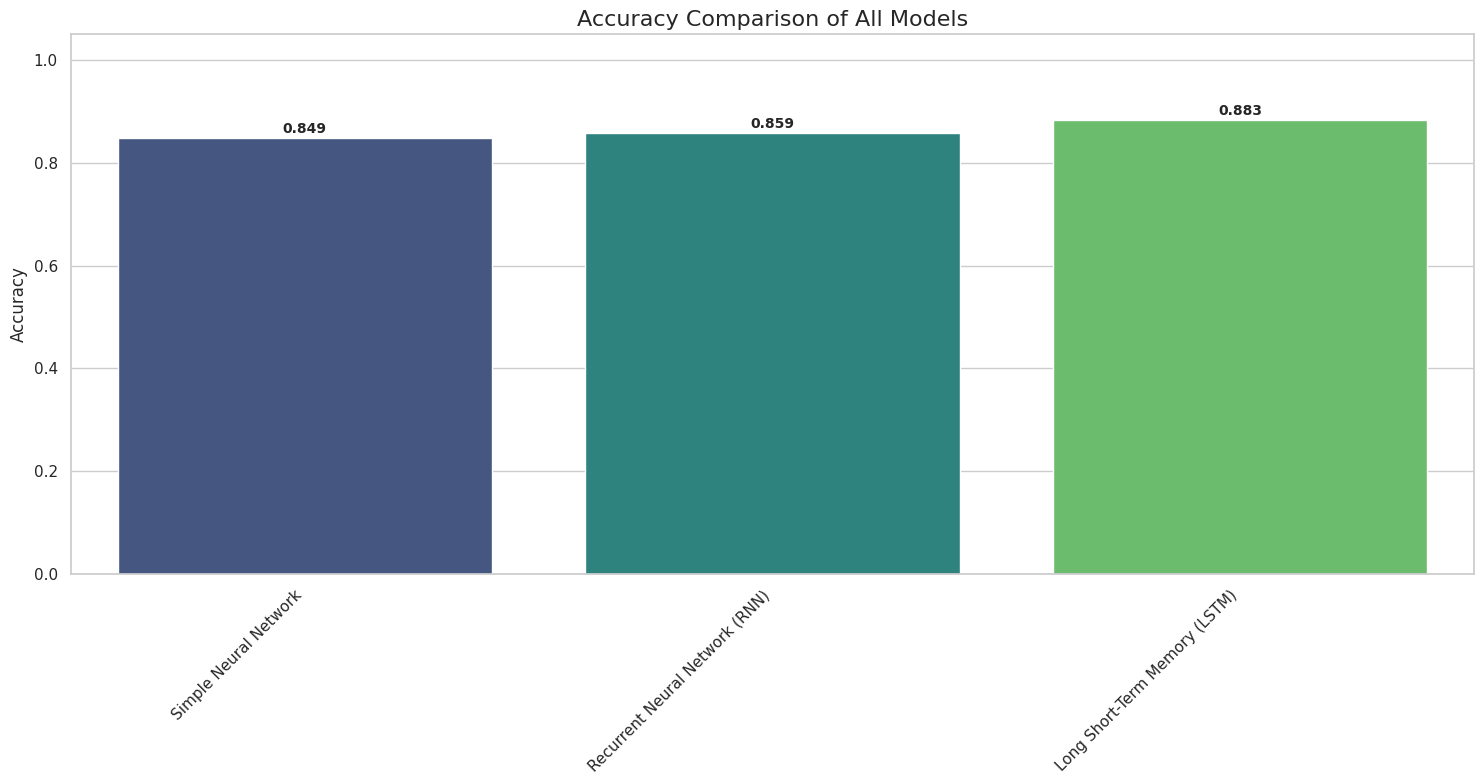


 Detailed Performance Summary for Each Model

 Model: Simple Neural Network
----------------------------------------
✅ Accuracy: 0.849

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      4961
           1       0.79      0.95      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000


 Confusion Matrix:
[[3698 1263]
 [ 247 4792]]

 Model: Recurrent Neural Network (RNN)
----------------------------------------
✅ Accuracy: 0.859

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4961
           1       0.84      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


 Confusion Matr

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

all_results = nn_results

# --- Plot Model Accuracy Comparison ---
print(" Generating accuracy comparison chart...")

plt.figure(figsize=(15, 8))
model_names = [result['name'] for result in all_results]
accuracies = [result['accuracy'] for result in all_results]

sns.set(style="whitegrid")
barplot = sns.barplot(x=model_names, y=accuracies, palette="viridis")

plt.title('Accuracy Comparison of All Models', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)  # Set y-axis limit for clarity

# Annotate each bar with accuracy value
for i, bar in enumerate(barplot.patches):
    barplot.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{accuracies[i]:.3f}',
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# --- Print Detailed Evaluation Results ---
print("\n Detailed Performance Summary for Each Model")
print("=" * 90)

for result in all_results:
    print(f"\n Model: {result['name']}")
    print("-" * 40)
    print(f"✅ Accuracy: {result['accuracy']:.3f}")
    print("\nClassification Report:")
    print(result['report'])
    print("\n Confusion Matrix:")
    print(result['confusion_matrix'])
    print("=" * 90)
